In [2]:
import pandas as pd
from tqdm import tqdm
from rapidfuzz import fuzz

In [ ]:
website_df = pd.read_csv("website_data_with_classifications.csv")

In [ ]:
website_df.head()

,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,...,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,category
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,Gifts Men | 11 Industries | Gentleman's Genera...,5651.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,Distillery | 11 Wells Distillery | Saint Paul ...,2082.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...","14th Rose - Handbags, Purses, Woman's Bags Fre...",3799.0
3,NaN,NaN,"Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...","Welcome Regal Ware, Inc. global leader quality...",...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Regal Ware | Enriching Life Bringing Families ...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,Home - Regal Ware Work Core Values Story Leade...,5082.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,Custom Swim Parkas Wholesale Fleece Jackets | ...,2369.0


In [ ]:
website_df["category"].count()

4309

In [ ]:
classification_col = website_df["category"]
classification_col = pd.Series([(str(int(x))[:2] if not pd.isnull(x) else "00") for x in classification_col])

In [ ]:
def ngram_text(text):
    text = text.lower()
    return [text[i:i+3] for i in range(0, len(text)-3+1)]


In [ ]:
FUZZY_MODE = False

In [ ]:
congresses = [110, 111, 112, 113, 114, 115, 116]
default_values = {}
for congress in congresses:
    phrase_df = pd.read_csv(f"Partisan Index/{congress}_congress_alpha_beta.csv")
    betas = phrase_df["beta"].tolist()
    alphas = phrase_df["alpha"].tolist()

    denominator = 0
    numerator = 0
    for (alpha, beta) in zip(alphas, betas):
        numerator += beta * -alpha
        denominator += beta * beta

    default_values[congress] = numerator / denominator

    print(f"Congress: {congress} ", " Value of Sum(beta_i * -alpha_i) / Sum(beta_i ^ 2): ", numerator/denominator)

Congress: 110   Value of Sum(beta_i * -alpha_i) / Sum(beta_i ^ 2):  0.5429763110878959
Congress: 111   Value of Sum(beta_i * -alpha_i) / Sum(beta_i ^ 2):  0.537753560663196
Congress: 112   Value of Sum(beta_i * -alpha_i) / Sum(beta_i ^ 2):  0.37690607211961086
Congress: 113   Value of Sum(beta_i * -alpha_i) / Sum(beta_i ^ 2):  0.29778211844105384
Congress: 114   Value of Sum(beta_i * -alpha_i) / Sum(beta_i ^ 2):  0.33861337237301475
Congress: 115   Value of Sum(beta_i * -alpha_i) / Sum(beta_i ^ 2):  0.487109637502079
Congress: 116   Value of Sum(beta_i * -alpha_i) / Sum(beta_i ^ 2):  0.43226759882950083


In [ ]:
for congress in default_values:
    default_values[congress] = 0.49

neutral = 0.5

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from rapidfuzz import fuzz, process
from functools import lru_cache

# session_year_map = {
#     2008: 110,
#     2012: 112,
#     2016: 114,
#     2020: 116
# }
session_year_map = {2007: 110, 2008: 110, 2009: 111, 2010: 111, 2011: 112, 2012: 112, 2013: 113, 2014: 113, 2015: 114, 2016: 114, 2017: 115, 2018: 115, 2019: 116, 2020: 116}
all_website_scores = []
all_website_scores_by_category = {category: [] for category in classification_col.unique()}

sum_year_scores = []
num_websites = []
year_std_devs = []

categorized_normalized_year_scores = {category: [] for category in classification_col.unique()}
categorized_year_std_devs = {category: [] for category in classification_col.unique()}

SIMILARITY_THRESHOLD = 90

@lru_cache(maxsize=100000)
def cached_partial_ratio(phrase, token):
    return fuzz.partial_ratio(phrase, token)

def count_matches(ngrams, phrase):
    curr_index = 0
    count = 0
    while curr_index < len(ngrams):
        if cached_partial_ratio(phrase, ngrams[curr_index]) >= SIMILARITY_THRESHOLD:
            count += 1
            curr_index += 3
        curr_index += 1
    return count

phrase_count_by_year = {}

USE_FILE = True
REMOVE_KEYWORDS = True

removal_keywords = ["credit card", "air force"]

if USE_FILE:
    import pickle
    if FUZZY_MODE:
        phrase_count_by_year = pickle.load(open("phrase_count_by_year_fuzzy.pkl", "rb"))
    else:
        phrase_count_by_year = pickle.load(open("phrase_count_by_year.pkl", "rb"))
    if REMOVE_KEYWORDS:
        for year in phrase_count_by_year:
            for keyword in removal_keywords:
                if keyword in phrase_count_by_year[year].columns:
                    phrase_count_by_year[year].drop(keyword, axis=1, inplace=True)
                else:
                    print("Keyword not found in DataFrame: ", year, keyword)

for year in session_year_map:
    session = session_year_map[year]
    keywords_df = pd.read_csv(f"Partisan Index/{session}_congress_alpha_beta.csv")
    clean_phrases = keywords_df["phrase_clean"]
    clean_phrases = clean_phrases.dropna()
    

    valid_columns = [col for col in website_df.columns if str(year) in col]
    subset = website_df[valid_columns[-1]] # select the last value within a given year
    print("Last valid column: ", valid_columns[-1])

    subset = subset.fillna("")
    subset = subset.astype(str)
    
    subset_split = subset.apply(ngram_text)

    if phrase_count_by_year.get(year) is not None:
        phrase_count = phrase_count_by_year[year]
    else:
        phrase_count = pd.DataFrame(0, index=website_df.index, columns=keywords_df["phrase_clean"])
        for phrase in tqdm(clean_phrases, total=len(clean_phrases)):
            if FUZZY_MODE:
                phrase_count[phrase] = subset_split.apply(lambda x: count_matches(x, phrase))
            else:
                pattern = re.escape(phrase)
                phrase_count[phrase] = subset.apply(lambda x: len(re.findall(pattern, x, re.IGNORECASE)))
        phrase_count_by_year[year] = phrase_count

    y_n_denominator = sum((beta * beta) for beta in keywords_df["beta"])
    unavailable_numerator = sum((beta * -alpha) for (beta, alpha) in zip(keywords_df["beta"], keywords_df["alpha"]))

    print("Unavailable numerator / denominator: ", unavailable_numerator / y_n_denominator)

    website_scores = []
    website_scores_by_category = {category: [] for category in classification_col.unique()}

    websites_count = 0
    neutral_website = 0

    for website in tqdm(phrase_count.index):
        website_stats = phrase_count.loc[website]
        valid_phrases = website_stats.index
        website_category = classification_col[website]

        if not subset.loc[website]:
            continue

        phrase_count_sum = website_stats.sum()
        
        if phrase_count_sum == 0:
            website_scores.append(neutral)
            website_scores_by_category[website_category].append(neutral)
            continue
        else:
            y_n_numerator = 0
            for phrase, beta, alpha in zip(keywords_df["phrase_clean"], keywords_df["beta"], keywords_df["alpha"]):
                if phrase in valid_phrases:
                    if phrase_count_sum == 0: # NOTE: this is inactive
                        print("error - this if statement should not be seen")
                        y_n_numerator += beta * (0 - alpha)
                    else:
                        y_n_numerator += beta * ((website_stats[phrase] / phrase_count_sum) - alpha)
            score = (y_n_numerator / y_n_denominator)

            if score > 1.5:
                modified_website_stats = website_stats.to_frame()
                print(modified_website_stats.value_counts())

            website_scores.append(score)
            website_scores_by_category[website_category].append(score)
            websites_count += 1
    all_website_scores.append(website_scores)
    # print("Websites count: ", websites_count, " Number of elements in website_scores: ", len(website_scores))

    sum_year_scores.append(np.sum(website_scores))
    num_websites.append(websites_count)
    year_std_devs.append(np.std(website_scores))

    for category in classification_col.unique():
        if len(website_scores_by_category[category]) == 0:
            # print(f"Category {category} had no websites in year {year}")
            continue
        all_website_scores_by_category[category].append(website_scores_by_category[category])
        categorized_normalized_year_scores[category].append(np.mean(website_scores_by_category[category]))
        categorized_year_std_devs[category].append(np.std(website_scores_by_category[category]))

    print(f"Year {year} score: {np.sum(website_scores) / websites_count}")

Keyword not found in DataFrame:  2011 credit card
Keyword not found in DataFrame:  2012 credit card
Keyword not found in DataFrame:  2013 credit card
Keyword not found in DataFrame:  2014 credit card
Keyword not found in DataFrame:  2015 credit card
Keyword not found in DataFrame:  2015 air force
Keyword not found in DataFrame:  2016 credit card
Keyword not found in DataFrame:  2016 air force
Keyword not found in DataFrame:  2017 credit card
Keyword not found in DataFrame:  2018 credit card
Keyword not found in DataFrame:  2019 credit card
Keyword not found in DataFrame:  2019 air force
Keyword not found in DataFrame:  2020 credit card
Keyword not found in DataFrame:  2020 air force
Last valid column:  2007-12
Unavailable numerator / denominator:  0.5429763110878958


100%|██████████| 5189/5189 [00:01<00:00, 3721.17it/s]


Year 2007 score: 8.580760240185153
Last valid column:  2008-12
Unavailable numerator / denominator:  0.5429763110878958


100%|██████████| 5189/5189 [00:01<00:00, 4026.42it/s]


Year 2008 score: 8.307792846251573
Last valid column:  2009-12
Unavailable numerator / denominator:  0.5377535606631955


 30%|███       | 1568/5189 [00:00<00:00, 3970.82it/s]

846
0      497
1        1
Name: count, dtype: int64


100%|██████████| 5189/5189 [00:01<00:00, 3926.79it/s]


Year 2009 score: 6.29366918991656
Last valid column:  2010-12
Unavailable numerator / denominator:  0.5377535606631955


 27%|██▋       | 1391/5189 [00:00<00:01, 3669.12it/s]

846
0      497
1        1
Name: count, dtype: int64


100%|██████████| 5189/5189 [00:01<00:00, 3552.86it/s]


Year 2010 score: 5.647519878333227
Last valid column:  2011-12
Unavailable numerator / denominator:  0.37690607211960997


  6%|▋         | 331/5189 [00:00<00:01, 3309.18it/s]

580
0      498
1        1
Name: count, dtype: int64


 74%|███████▍  | 3865/5189 [00:01<00:00, 3755.89it/s]

3119
0       498
2         1
Name: count, dtype: int64


 90%|█████████ | 4678/5189 [00:01<00:00, 3913.07it/s]

4245
0       498
1         1
Name: count, dtype: int64


100%|██████████| 5189/5189 [00:01<00:00, 3783.18it/s]


5147
0       498
1         1
Name: count, dtype: int64
Year 2011 score: 8.701688182088498
Last valid column:  2012-12
Unavailable numerator / denominator:  0.37690607211960997


 73%|███████▎  | 3770/5189 [00:01<00:00, 3964.68it/s]

3119
0       498
2         1
Name: count, dtype: int64


 96%|█████████▌| 4985/5189 [00:01<00:00, 3920.58it/s]

4245
0       498
1         1
Name: count, dtype: int64


100%|██████████| 5189/5189 [00:01<00:00, 3782.79it/s]


Year 2012 score: 7.151715172388647
Last valid column:  2013-12
Unavailable numerator / denominator:  0.29778211844105434


  4%|▎         | 188/5189 [00:00<00:02, 1870.72it/s]

235
0      498
1        1
Name: count, dtype: int64
437
0      498
3        1
Name: count, dtype: int64


 16%|█▌        | 842/5189 [00:00<00:01, 2979.25it/s]

526
0      498
1        1
Name: count, dtype: int64


 37%|███▋      | 1913/5189 [00:00<00:00, 3288.55it/s]

1705
0       498
1         1
Name: count, dtype: int64


 54%|█████▍    | 2821/5189 [00:01<00:00, 2656.55it/s]

2475
0       498
1         1
Name: count, dtype: int64
2544
0       498
1         1
Name: count, dtype: int64


 73%|███████▎  | 3808/5189 [00:01<00:00, 3072.22it/s]

3219
0       498
1         1
Name: count, dtype: int64


 95%|█████████▍| 4927/5189 [00:01<00:00, 3524.14it/s]

4263
0       498
1         1
Name: count, dtype: int64
4750
0       498
1         1
Name: count, dtype: int64
4885
0       498
1         1
Name: count, dtype: int64
5036
0       498
1         1
Name: count, dtype: int64


100%|██████████| 5189/5189 [00:01<00:00, 3042.02it/s]


Year 2013 score: 7.24092816896909
Last valid column:  2014-12
Unavailable numerator / denominator:  0.29778211844105434


  3%|▎         | 176/5189 [00:00<00:02, 1757.40it/s]

235
0      498
1        1
Name: count, dtype: int64
437
0      498
3        1
Name: count, dtype: int64
526
0      498
1        1
Name: count, dtype: int64


 18%|█▊        | 925/5189 [00:00<00:01, 3295.56it/s]

662
0      497
1        1
3        1
Name: count, dtype: int64


 48%|████▊     | 2471/5189 [00:00<00:00, 3741.77it/s]

1705
0       498
1         1
Name: count, dtype: int64
1986
0       498
1         1
Name: count, dtype: int64
2475
0       498
1         1
Name: count, dtype: int64
2544
0       498
1         1
Name: count, dtype: int64


 77%|███████▋  | 3984/5189 [00:01<00:00, 3505.19it/s]

3219
0       498
1         1
Name: count, dtype: int64
4105
0       498
1         1
Name: count, dtype: int64


 99%|█████████▉| 5149/5189 [00:01<00:00, 3759.25it/s]

4263
0       498
1         1
Name: count, dtype: int64
4650
0       498
3         1
Name: count, dtype: int64
4750
0       498
1         1
Name: count, dtype: int64


100%|██████████| 5189/5189 [00:01<00:00, 3470.68it/s]


Year 2014 score: 7.288229876082244
Last valid column:  2015-12
Unavailable numerator / denominator:  0.33861337237301475


 43%|████▎     | 2240/5189 [00:00<00:00, 3145.18it/s]

1747
0       499
1         1
Name: count, dtype: int64


 94%|█████████▎| 4856/5189 [00:01<00:00, 3742.70it/s]

4362
0       499
1         1
Name: count, dtype: int64
5074
0       499
1         1
Name: count, dtype: int64


100%|██████████| 5189/5189 [00:01<00:00, 3254.59it/s]


Year 2015 score: 5.44198095052901
Last valid column:  2016-12
Unavailable numerator / denominator:  0.33861337237301475


 85%|████████▌ | 4414/5189 [00:01<00:00, 3481.65it/s]

3930
0       499
1         1
Name: count, dtype: int64
4362
0       499
1         1
Name: count, dtype: int64


100%|██████████| 5189/5189 [00:01<00:00, 3279.62it/s]


5074
0       499
1         1
Name: count, dtype: int64
Year 2016 score: 4.792071342171545
Last valid column:  2017-12
Unavailable numerator / denominator:  0.4871096375020792


  4%|▍         | 231/5189 [00:00<00:02, 2300.07it/s]

213
0      498
1        1
Name: count, dtype: int64
220
0      498
1        1
Name: count, dtype: int64
221
0      498
1        1
Name: count, dtype: int64
268
0      498
1        1
Name: count, dtype: int64


 16%|█▌        | 832/5189 [00:00<00:01, 2850.86it/s]

578
0      498
1        1
Name: count, dtype: int64
663
0      498
1        1
Name: count, dtype: int64


 23%|██▎       | 1180/5189 [00:00<00:01, 3098.54it/s]

933
0      498
1        1
Name: count, dtype: int64
934
0      498
1        1
Name: count, dtype: int64
999
0      498
1        1
Name: count, dtype: int64
1202
0       498
1         1
Name: count, dtype: int64


 29%|██▉       | 1505/5189 [00:00<00:01, 3120.33it/s]

1445
0       498
1         1
Name: count, dtype: int64


 35%|███▌      | 1818/5189 [00:00<00:01, 2884.86it/s]

1877
0       498
1         1
Name: count, dtype: int64


 48%|████▊     | 2495/5189 [00:00<00:00, 3119.74it/s]

2313
0       498
1         1
Name: count, dtype: int64
2346
0       497
3         1
11        1
Name: count, dtype: int64
2471
0       498
2         1
Name: count, dtype: int64
2515
0       498
1         1
Name: count, dtype: int64
2544
0       498
1         1
Name: count, dtype: int64


 55%|█████▍    | 2834/5189 [00:00<00:00, 3201.23it/s]

2848
0       498
1         1
Name: count, dtype: int64
2975
0       498
4         1
Name: count, dtype: int64


 67%|██████▋   | 3495/5189 [00:01<00:00, 3179.54it/s]

3216
0       498
1         1
Name: count, dtype: int64
3400
0       498
1         1
Name: count, dtype: int64


 74%|███████▎  | 3815/5189 [00:01<00:00, 2977.81it/s]

3843
0       498
4         1
Name: count, dtype: int64

 86%|████████▋ | 4482/5189 [00:01<00:00, 3155.47it/s]


4175
0       498
1         1
Name: count, dtype: int64
4261
0       498
1         1
Name: count, dtype: int64
4434
0       498
2         1
Name: count, dtype: int64
4647
0       498
1         1
Name: count, dtype: int64


100%|██████████| 5189/5189 [00:01<00:00, 3122.29it/s]


4924
0       498
1         1
Name: count, dtype: int64
5061
0       498
1         1
Name: count, dtype: int64
5108
0       498
1         1
Name: count, dtype: int64
Year 2017 score: 5.9494373539775465
Last valid column:  2018-12
Unavailable numerator / denominator:  0.4871096375020792


  4%|▍         | 223/5189 [00:00<00:02, 2225.97it/s]

5
0    498
1      1
Name: count, dtype: int64
132
0      497
1        1
17       1
Name: count, dtype: int64
213
0      498
1        1
Name: count, dtype: int64
220
0      498
1        1
Name: count, dtype: int64
221
0      498
1        1
Name: count, dtype: int64
268
0      498
1        1
Name: count, dtype: int64
526
0      498
1        1
Name: count, dtype: int64


 11%|█         | 552/5189 [00:00<00:01, 2850.35it/s]

578
0      498
1        1
Name: count, dtype: int64


 16%|█▌        | 838/5189 [00:00<00:01, 2854.10it/s]

663
0      498
1        1
Name: count, dtype: int64
933
0      498
1        1
Name: count, dtype: int64
934
0      498
1        1
Name: count, dtype: int64
999
0      498
1        1
Name: count, dtype: int64


 22%|██▏       | 1124/5189 [00:00<00:01, 2512.00it/s]

1084
0       497
4         1
9         1
Name: count, dtype: int64
1158
0       498
2         1
Name: count, dtype: int64


 27%|██▋       | 1424/5189 [00:00<00:01, 2672.78it/s]

1497
0       498
1         1
Name: count, dtype: int64
1598
0       498
1         1
Name: count, dtype: int64


 40%|████      | 2098/5189 [00:00<00:01, 3036.69it/s]

1877
0       498
1         1
Name: count, dtype: int64
2158
0       498
2         1
Name: count, dtype: int64


 46%|████▋     | 2411/5189 [00:00<00:00, 3058.74it/s]

2313
0       498
1         1
Name: count, dtype: int64
2471
0       498
2         1
Name: count, dtype: int64
2544
0       498
1         1
Name: count, dtype: int64


 52%|█████▏    | 2720/5189 [00:00<00:00, 2623.07it/s]

2626
0       498
1         1
Name: count, dtype: int64
2784
0       498
1         1
Name: count, dtype: int64
2848
0       498
1         1
Name: count, dtype: int64


 58%|█████▊    | 3018/5189 [00:01<00:00, 2718.13it/s]

2975
0       498
5         1
Name: count, dtype: int64


 70%|██████▉   | 3612/5189 [00:01<00:00, 2849.59it/s]

3400
0       498
1         1
Name: count, dtype: int64


 76%|███████▌  | 3955/5189 [00:01<00:00, 3016.88it/s]

3615
0       498
1         1
Name: count, dtype: int64
3687
0       498
1         1
Name: count, dtype: int64
3745
0       498
1         1
Name: count, dtype: int64
3843
0       498
4         1
Name: count, dtype: int64


 83%|████████▎ | 4297/5189 [00:01<00:00, 3129.11it/s]

4175
0       498
1         1
Name: count, dtype: int64
4261
0       498
1         1
Name: count, dtype: int64
4286
0       498
2         1
Name: count, dtype: int64
4296
0       498
1         1
Name: count, dtype: int64


100%|██████████| 5189/5189 [00:01<00:00, 2918.68it/s]


5061
0       498
1         1
Name: count, dtype: int64
5108
0       498
1         1
Name: count, dtype: int64
5178
0       498
2         1
Name: count, dtype: int64
Year 2018 score: 5.999542064563428
Last valid column:  2019-12
Unavailable numerator / denominator:  0.4322675988295009


100%|██████████| 5189/5189 [00:01<00:00, 2987.17it/s]


Year 2019 score: 4.495521029561298
Last valid column:  2020-12
Unavailable numerator / denominator:  0.4322675988295009


100%|██████████| 5189/5189 [00:01<00:00, 3165.42it/s]

Year 2020 score: 3.933194787185579


In [ ]:
for i in range(len(all_website_scores[-1])):
    if all_website_scores[-1][i] > 1:
        print("Website: ", str(website_df["2020-12"][i])[:200], " - ", all_website_scores[-1][i])

Website:  270 SMOKERS Skip content Submit Close search Home SMOKERS Accessories Replacement Parts 270 Apparel Cooks Tools & Seasonings Dealer Network Upcoming Events Classes Contact Us Home SMOKERS Accessories   -  1.2522402922601188
Website:  9B Apparel 9B Apparel Us Development/Production Factories Policies policies Downloadable documents Us/ Development/Production/ Factories/ Policies/Our policiesDownloadable documents Trusted Domestic A  -  1.2440398446662289
Website:  Home - AccuStrike Welding Helmet Home Products Testimonials Great Deals Shop Now! Learn Works VIDEOS & PHOTOS Click Products Shop FAQ Frequently Asked Questions Distributors Distributor List. get touc  -  1.2440398446662289
Website:  Alfa Romeo: passion driving technology top Models Brand Racing Store Area Select Country Dealers New Giulia GTA Discover Quadrifoglio Discover STELVIO Car Configurator Discover GIULIA Car Configurator  -  1.1217729774459073
Website:  Dan Gurney's American Racers Home Dan Gurney Bio Caree

Number of scores:  2304
Number of scores:  3096
Number of scores:  3942
Number of scores:  4341


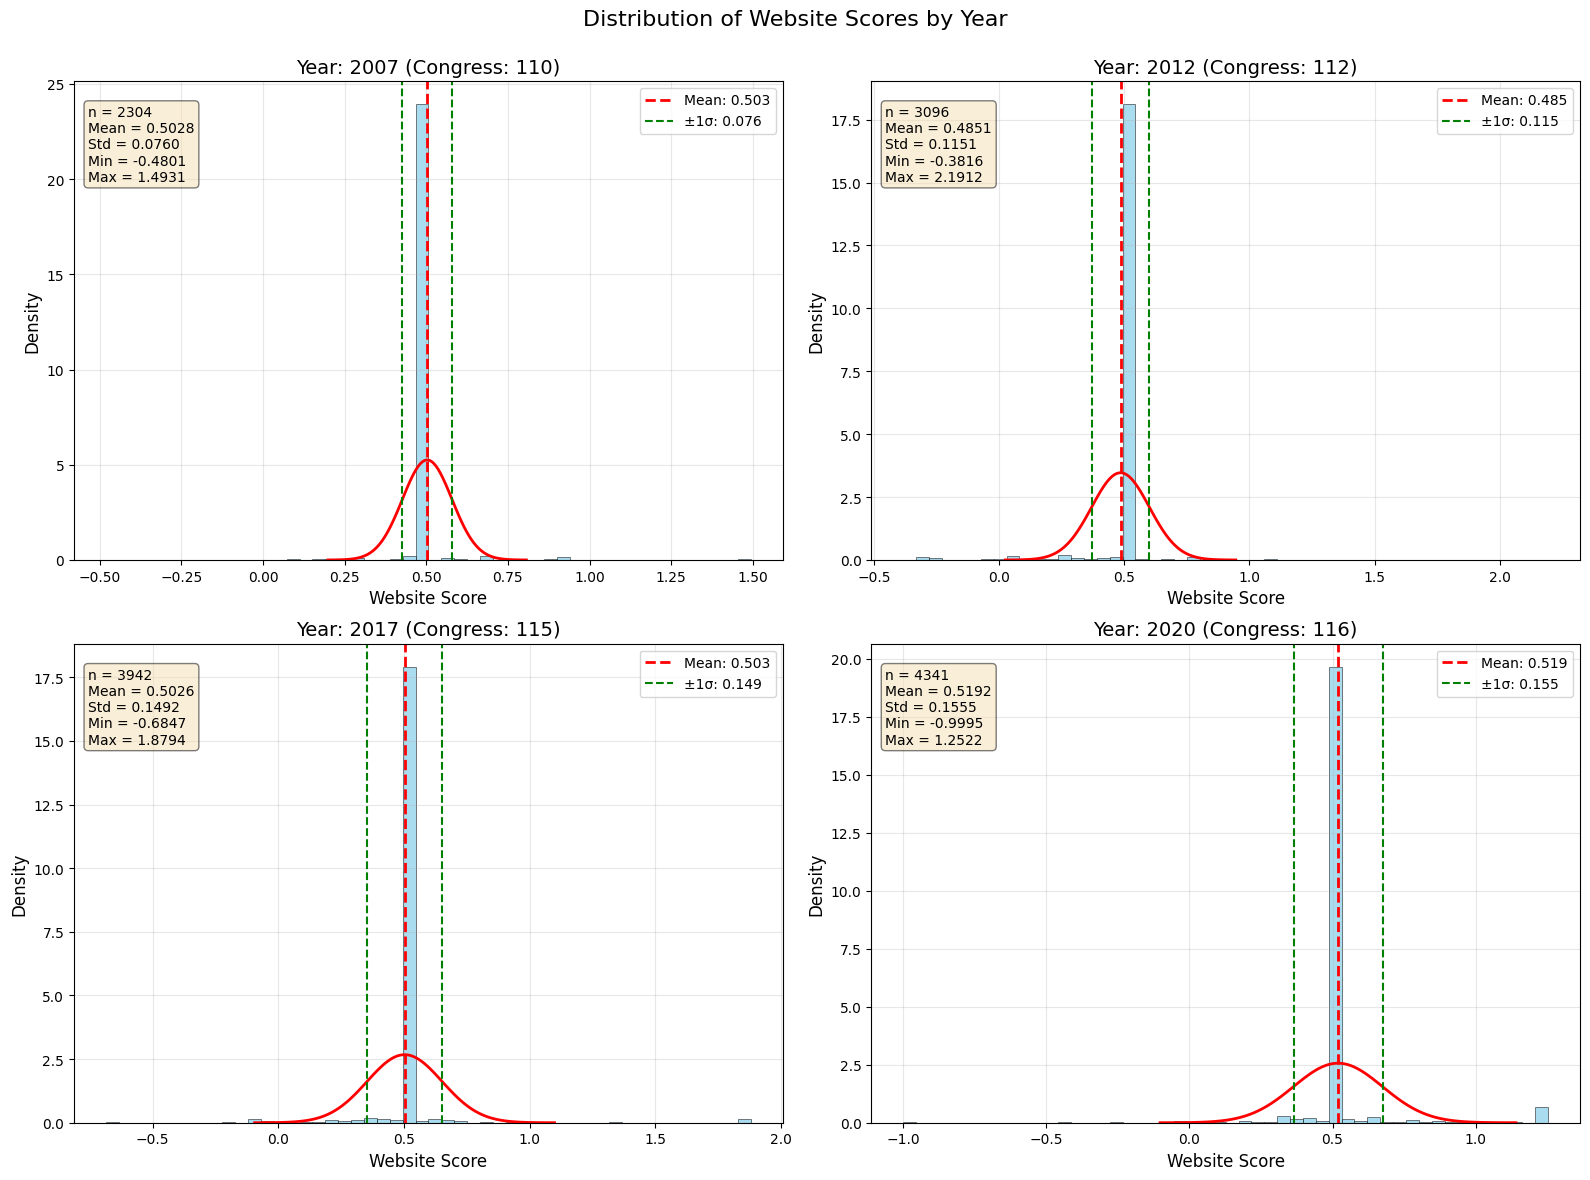

In [ ]:
# claude visualization

import numpy as np

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution of Website Scores by Year', fontsize=16)

# Flatten the axes for easier iteration
axes = axes.flatten()

for i, year_idx in enumerate([0, 5, 10, 13]):  # Sample early, middle, and recent years
    year = list(session_year_map.keys())[year_idx]
    scores = all_website_scores[year_idx]
    print("Number of scores: ", len(scores))
    # scores = scores[:200]
    
    # Calculate statistics
    mean = np.mean(scores)
    std = np.std(scores)
    
    # Plot histogram with density curve
    ax = axes[i]
    n, bins, patches = ax.hist(scores, bins=50, alpha=0.7, density=True, 
                               color='skyblue', edgecolor='black', linewidth=0.5)
    
    # Add normal distribution curve
    x = np.linspace(mean - 4*std, mean + 4*std, 100)
    y = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    ax.plot(x, y, 'r-', linewidth=2)
    
    # Add vertical lines for mean and standard deviations
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
    ax.axvline(mean + std, color='green', linestyle='dashed', linewidth=1.5, label=f'±1σ: {std:.3f}')
    ax.axvline(mean - std, color='green', linestyle='dashed', linewidth=1.5)
    
    # Add title and labels
    ax.set_title(f'Year: {year} (Congress: {session_year_map[year]})', fontsize=14)
    ax.set_xlabel('Website Score', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Add text with statistics
    text = f'n = {len(scores)}\nMean = {mean:.4f}\nStd = {std:.4f}\nMin = {min(scores):.4f}\nMax = {max(scores):.4f}'
    ax.text(0.02, 0.95, text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [ ]:
import numpy as np
print([np.mean(scores) for scores in all_website_scores])
print([np.std(scores) for scores in all_website_scores])

[0.47626096564669773, 0.4724922400648449, 0.43777011211960654, 0.42971634267940756, 0.45238321620025584, 0.43627919005272336, 0.44813673177700125, 0.44960244359839796, 0.4212033482490431, 0.41079231625743556, 0.4629186397131016, 0.4699716441439524, 0.4790295912512242, 0.4723430606115348]
[0.17786551429201022, 0.18853856058593932, 0.30121308821476805, 0.31889083744226, 0.2781972792074859, 0.31074836313227105, 0.2961347913985753, 0.2980912805251181, 0.3142904965119643, 0.33062423111955763, 0.3219197031598028, 0.331451916239617, 0.2809672519137723, 0.30343134476700817]


In [ ]:
print([np.sum(scores) for scores in all_website_scores])

[1097.3052648499915, 1150.9910967979622, 1122.8803375867908, 1167.5393030599503, 1340.8638528175584, 1350.7203724032315, 1486.9176760360901, 1586.197421015148, 1552.5555416459729, 1569.226648103404, 1824.8252777490466, 1922.1840245487654, 1994.2001883788462, 2050.4412261146726]


Minimum:  0.41079231625743556
Maximum:  0.4790295912512242


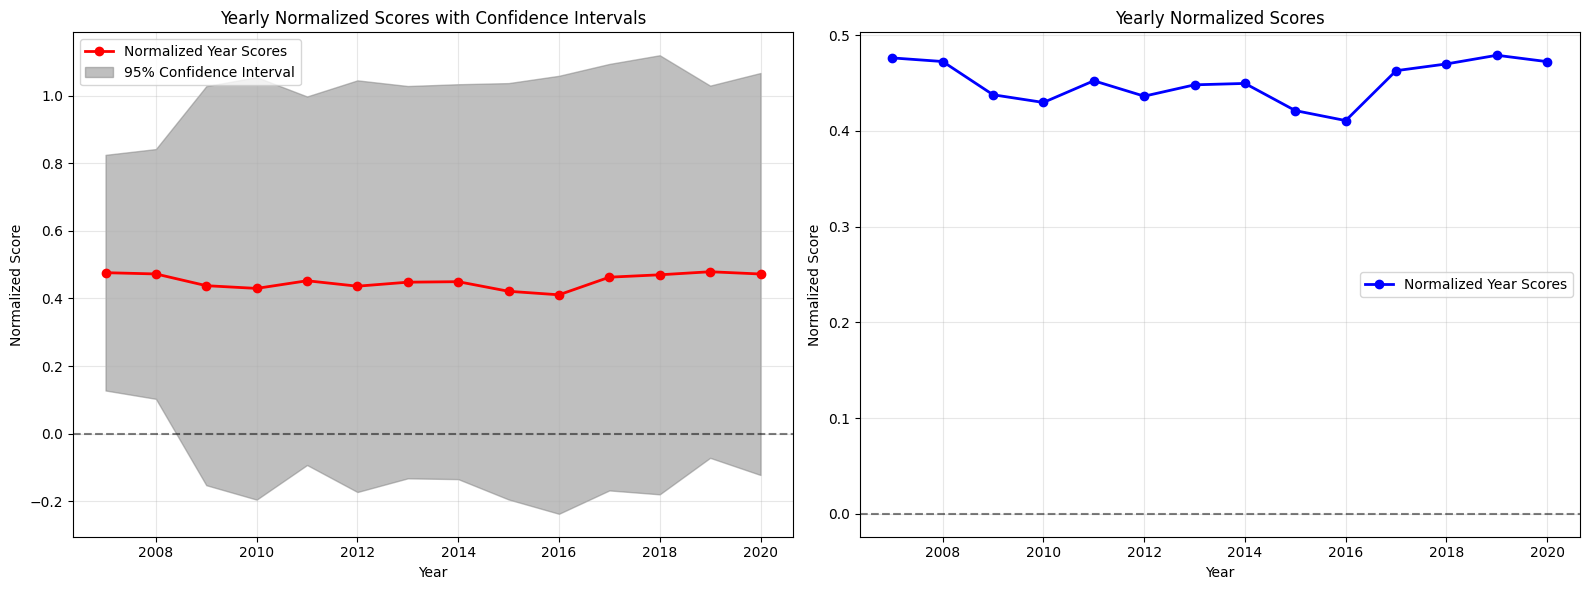

Normalized year scores (centered): [0.4763, 0.4725, 0.4378, 0.4297, 0.4524, 0.4363, 0.4481, 0.4496, 0.4212, 0.4108, 0.4629, 0.47, 0.479, 0.4723]
Years: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [ ]:
import matplotlib.pyplot as plt

years = list(session_year_map.keys())
normalized_year_scores = [np.mean(scores) for scores in all_website_scores]
# normalized_year_scores = [scores * 2 - 1 for scores in normalized_year_scores]  # Normalize to [0, 1] range
# Calculate mean of means to center the plots
# mean_of_means = np.mean(normalized_year_scores)
mean_of_means = 0

print("Minimum: ", min(normalized_year_scores))
print("Maximum: ", max(normalized_year_scores))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: With confidence intervals
ax1.plot(years, [(score - mean_of_means) for score in normalized_year_scores], 
         marker='o', color='r', linewidth=2, label='Normalized Year Scores')
ax1.fill_between(years, 
                 [score - mean_of_means - 1.96*std for score, std in zip(normalized_year_scores, year_std_devs)], 
                 [score - mean_of_means + 1.96*std for score, std in zip(normalized_year_scores, year_std_devs)], 
                 color='gray', alpha=0.5, label='95% Confidence Interval')
ax1.set_xlabel('Year')
ax1.set_ylabel('Normalized Score')
ax1.set_title('Yearly Normalized Scores with Confidence Intervals')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Without confidence intervals
ax2.plot(years, [(score - mean_of_means) for score in normalized_year_scores], 
         marker='o', color='b', linewidth=2, label='Normalized Year Scores')
ax2.set_xlabel('Year')
ax2.set_ylabel('Normalized Score')
ax2.set_title('Yearly Normalized Scores')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add a horizontal line at y=0 for reference in both plots
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print the values for reference
print("Normalized year scores (centered):", [round(score - mean_of_means, 4) for score in normalized_year_scores])
print("Years:", years)

In [ ]:
default_values

{110: 0.49, 111: 0.49, 112: 0.49, 113: 0.49, 114: 0.49, 115: 0.49, 116: 0.49}

In [ ]:
mean_of_means

0

In [ ]:
import pickle

for year in phrase_count_by_year:
    print("Year: ", year)
    print(phrase_count_by_year[year].sum(axis=0).sort_values(ascending=False).head(15))
    print("\n\n----\n\n")

Year:  2007
phrase_clean
new mexico           30
natural gas          20
health care          17
health insurance     14
god bless            12
student loan         11
made order            9
civil war             8
white house           7
renewable energy      6
consumer product      6
homeland security     5
solve problem         5
get health            5
health safety         5
dtype: int64


----


Year:  2008
phrase_clean
new mexico          29
health care         17
renewable energy    15
made order          15
god bless           12
health insurance    11
civil war           10
consumer product     9
student loan         9
white house          8
solve problem        6
get health           6
power plant          6
natural gas          5
gas price            4
dtype: int64


----


Year:  2009
phrase_clean
native american      32
new mexico           26
rhode island         24
look forward         23
one thing            17
health care          15
hard work            15
peace mi